# **ACOPF - SLP**

Essential functions are stored inside the pyhton module called **acopf** .       
    acopf.slp - *ModelBuilder* to set up and adjust the ACOPF-LP-approximation   
    acopf.utils - Functions for data import parameter calculation.   
    

In [1]:
import sys
sys.path.append('../acopf')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import acopf.slp as slp
import acopf.utils as utils
import acopf.config as config

## **Import Data**

Uncomment the data files that should be used.

In [6]:
bus_file = os.path.join(config.data_dir,"01_test_cases/WB5/bus_data.CSV")
print(bus_file)
wb5 = pd.read_csv(bus_file, sep=';')

wb5

..\data\01_test_cases/WB5/bus_data.CSV


,bus_i,type,Pd,Qd,Gs,Bs,Vmax,Vmin,Qmax,Qmin,Pmax,Pmin,baseMVA,baseKV
0,1,3,0.00,0.0,0,0,1.05,0.95,18,-0.3,50,0,100,345
1,2,1,1.30,0.2,0,0,1.05,0.95,0,0.0,0,0,100,345
2,3,1,1.30,0.2,0,0,1.05,0.95,0,0.0,0,0,100,345
3,4,1,0.65,0.1,0,0,1.05,0.95,0,0.0,0,0,100,345
4,5,2,0.00,0.0,0,0,1.05,0.95,18,-0.3,50,0,100,345


In [3]:

# WB2
#bus_file = "Data/WB2/bus_data.CSV"
#branch_file = "Data/WB2/branch_data.CSV"
#gen_file = "Data/WB2/gen_data.CSV"
#cost_file = "Data/WB2/cost_data.CSV"

# WB5
bus_file = "Data/WB5/bus_data.CSV"
branch_file = "Data/WB5/branch_data.CSV"
gen_file = "Data/WB5/gen_data.CSV"
cost_file = "Data/WB5/cost_data.CSV"

# case22loop
# bus_file = "Data/case22loop/bus_data.CSV"
# branch_file = "Data/case22loop/branch_data.CSV"
# gen_file = "Data/case22loop/gen_data.CSV"
# cost_file = "Data/case22loop/cost_data.CSV"

data_importer = utils.DataImporter(bus_file, branch_file, gen_file, cost_file)
bus_data = data_importer.import_bus_data()
branch_data = data_importer.import_branch_data()
gen_data = data_importer.import_gen_data()
cost_data = data_importer.import_cost_data()

print('Bus Data')
print(bus_data)
print()
print('Branch Data')
print(branch_data)
print()
print('Generator Data')
print(gen_data)
print()
print('Cost Data')
print(cost_data)
print()


Bus Data
   bus_i  type    Pd   Qd  Gs  Bs  Vmax  Vmin  Qmax  Qmin  Pmax  Pmin  \
0      1     3  0.00  0.0   0   0  1.05  0.95    18  -0.3    50     0   
1      2     1  1.30  0.2   0   0  1.05  0.95     0   0.0     0     0   
2      3     1  1.30  0.2   0   0  1.05  0.95     0   0.0     0     0   
3      4     1  0.65  0.1   0   0  1.05  0.95     0   0.0     0     0   
4      5     2  0.00  0.0   0   0  1.05  0.95    18  -0.3    50     0   

   baseMVA  baseKV  
0      100     345  
1      100     345  
2      100     345  
3      100     345  
4      100     345  

Branch Data
   fbus  tbus     r     x     b  Pmax  Imax  baseMVA  baseKV
0     1     2  0.04  0.09  0.00    25    25      100     345
1     1     3  0.05  0.01  0.00    25    25      100     345
2     2     3  0.07  0.09  0.00    25    25      100     345
3     2     4  0.55  0.90  0.45    25    25      100     345
4     3     5  0.55  0.90  0.45    25    25      100     345
5     4     5  0.06  0.10  0.00    25    25    

**Data is prepared to fit the algorithm.**   

Important parameters could be adjustet here. E.g.:
+ Number of objective function segments
+ Initial evaluation points
+ Penalty factors
+ Step-size parameters

In [4]:
#############################################
# Data
#############################################

# Structural data
lines = {
    'nm': [(x,y) for x,y in zip(branch_data['fbus'], branch_data['tbus'])],
    'mn': [(y,x) for x,y in zip(branch_data['fbus'], branch_data['tbus'])]
}
buses = bus_data['bus_i'].tolist()
gen_buses = gen_data['bus'].tolist()
n_buses = len(buses)
n_obj_segments = 4

# Base
base_mva = bus_data['baseMVA'][0]
base_kv = bus_data['baseKV'][0]

# Bus data
pn_d = bus_data['Pd'].tolist()
qn_d = bus_data['Qd'].tolist()
gn_shunt = bus_data['Gs'].tolist()
bn_shunt =  bus_data['Bs'].tolist()
v_min = bus_data['Vmin'].tolist()
v_max = bus_data['Vmax'].tolist()
v_max = [1.1]*len(v_min)
p_max = bus_data['Pmax'].tolist()
p_min = bus_data['Pmin'].tolist()
q_max = bus_data['Qmax'].tolist()
q_min = bus_data['Qmin'].tolist()

# Branch data
r = branch_data['r'].tolist()
x = branch_data['x'].tolist()
b_shunt = branch_data['b'].tolist()
g_shunt = [0]*len(b_shunt)
i_max = branch_data['Imax'].tolist()

# Generator data
p_gen_max = gen_data['Pmax'].tolist()
p_gen_min = gen_data['Pmin'].tolist()


#############################################
# Parameters
#############################################
pc = utils.ParameterCalculator()

# Costs
c1 = [c*base_mva for c in cost_data['c1'].tolist()]
c2 = [c*base_mva**2 for c in cost_data['c2'].tolist()]
costs_generators = pc.get_pwl_coefficients(c1, c2, p_gen_min, p_gen_max, base_mva, n_obj_segments)

# Penalty factors
pn_viol_fac = [2.5*max(c1)]*n_buses
qn_viol_fac = [12.5*max(c1)]*n_buses
vn_viol_fac = [15*max(c1)]*n_buses
ik_viol_fac = [25*max(c1)]*len(lines['nm'])*2

# Step-size parameters
step_size_a = 0.25
step_size_b = 1.5

# Admittance
yk_matrices = pc.get_yk_matrices( r, x, g_shunt, b_shunt)


#############################################
# Initial evaluation points
#############################################

# Initialization like flat start 
vnr_eva = [1]*n_buses
vnj_eva = [0]*n_buses
inr_eva = gn_shunt
inj_eva = [0]*n_buses
i_ini_nm = [yk[0].dot(np.array([1,1])) for yk in yk_matrices]
i_ini_mn = [yk[1].dot(np.array([1,1])) for yk in yk_matrices]
i_ini = i_ini_nm+i_ini_mn
ikr_eva = [i.real for i in i_ini]
ikj_eva = [i.imag for i in i_ini]

Define directory, where models and solutions should be written to:

In [5]:
gurobi_directory = "Gurobi_write"
if not os.path.exists(gurobi_directory):
    os.makedirs(gurobi_directory)

## **Model Setup**

In [6]:
mb = slp.ModelBuilder(n_buses, gen_buses, n_obj_segments, lines)

mb.add_objective(costs_generators, pn_viol_fac, qn_viol_fac, vn_viol_fac, ik_viol_fac)
mb.add_obj_constraints(p_gen_min, p_gen_max)
mb.add_flow_constraints( yk_matrices, gn_shunt, bn_shunt)
mb.add_box_constraints( v_max, i_max)
mb.add_taylor_constraints(vnr_eva, vnj_eva, inr_eva, inj_eva, ikr_eva, ikj_eva, pn_d, qn_d)
mb.add_power_constraints(p_min, p_max, q_min, q_max)
mb.add_iv_constraints(v_min, v_max, i_max)


--------------------------------------------
--------------------------------------------

Using license file C:\Users\Leo\gurobi.lic
Academic license - for non-commercial use only


## **First Iteration**

**Optimization problem is written to files inside the present folder:**

modelit0.lp - Gurobi model after first iteratation.   
solit0.sol - Solution of the first iteration.

In [7]:
#mb.model.setParam('LogFile', 'Gurobi_LogFile')
mb.model.setParam('Threads', 4)

# Default method chooses automatically (e.g. depending on available threads)
#mb.model.setParam('Method', 0) # primal simplex
mb.model.setParam('Method', 1) # dual simplex
#mb.model.setParam('Method', 2) # barrier method

start_time_0 = time.time()
mb.run()
end_time_0 = time.time()
duration_0 = end_time_0-start_time_0

mb.write_model(gurobi_directory+r'/modelit0')
mb.write_solution(gurobi_directory+r'/solit0')

Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Changed value of parameter Method to 1
   Prev: -1  Min: -1  Max: 5  Default: -1
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 181 rows, 121 columns and 370 nonzeros
Model fingerprint: 0x9e5ce702
Coefficient statistics:
  Matrix range     [4e-01, 2e+01]
  Objective range  [1e+02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 6e+02]
Presolve removed 162 rows and 92 columns
Presolve time: 0.00s
Presolved: 19 rows, 29 columns, 141 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.501660e-01   0.000000e+00      0s
      20    7.8588859e+02   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds
Optimal objective  7.858885948e+02


## **Multiple Runs**

Adjust *number_of_runs* to define the maximum number of iterations.

**At the end of all iterations, model and solutions are written to the files:**   
   modelit(number_of_runs).lp   
   solit(number_of_runs).sol
   

**If some error occurs or the algorithm terminates premature (i.e. before reaching the defined number of runs), model and solution of the last valid iteration could be found in:**   
   current_model.lp   
   current_solution.sol   

**If the model of an iteration is likely to be infeasible, gurobi will try to export the Irreducible Inconsistent Subsystem (IIS).**   

**A *gamma_tolerance* is used to prevent errors occurring due to Gurobi's tolerance and the algorithm's calculations (in particular step-size calculations).**   
   "Smaller *gamma_tolerance*" means, that solutions are able to get closer to ACOPF feasibility.   
   **But:** The smaller the tolerance, the more likely conflicts may occur.
   (Gurobi's tolerance leads to a negative *gamma* and calculating step size, which includes *log(gamma)* will throw an error.)
   



**!!! It cannot be ruled out that errors occur which are not handled below. !!!**

In [8]:
number_of_runs = 100
gamma_tolerance = 10**(-12)

############################################################
# Prepare subsequent runs
############################################################
mb.model.setParam('OutputFlag', 0)
write_solution = False
current_run = 0

# To extract values before extraction is impossible due to infeasibility or model adjustment
pn_extract = []
qn_extract = []
vnr_extract = []
vnj_extract = []
inr_extract = []
inj_extract = []
ikr_extract = []
ikj_extract = []

# Runtime mesurement
end_time = None
start_time = time.time()

############################################################
# Successive algorithm
############################################################
while current_run < number_of_runs: 
    current_run += 1
    mb.write_model(gurobi_directory+r'/current_model')
    mb.write_solution(gurobi_directory+r'/current_solution')
    
    # New evalutaion points
    try:        
        vnr_eva_dict = {key: vnr.x for key, vnr in mb.v_n_r.items()}
        vnj_eva_dict = {key: vnj.x for key, vnj in mb.v_n_j.items()}
        inr_eva_dict = {key: inr.x for key, inr in mb.i_n_r.items()}
        inj_eva_dict = {key: inj.x for key, inj in mb.i_n_j.items()}
        ikr_eva_dict = {key: ikr.x for key, ikr in mb.i_k_r.items()}
        ikj_eva_dict = {key: inj.x for key, inj in mb.i_k_j.items()}
        # Value extraction
        pn_extract = [pn.x for pn in mb.p_n.values()]
        qn_extract = [qn.x for qn in mb.q_n.values()]
        vnr_extract = list(vnr_eva_dict.values())
        vnj_extract = list(vnj_eva_dict.values())
        inr_extract = list(inr_eva_dict.values())
        inj_extract = list(inj_eva_dict.values())
        ikr_extract = list(ikr_eva_dict.values())
        ikj_extract = list(ikj_eva_dict.values())
    except AttributeError as aerr:
        print('Iteration', current_run,': Model might be infeasible: ', aerr)
        mb.write_model('Infeasible_Model')
        mb.write_iis()
        raise
    
    # Adjust evaluation points
    vn_updated_keys = pc.update_iv_eva_points(vnr_eva_dict, vnj_eva_dict, v_max)
    ik_updated_keys = pc.update_iv_eva_points(ikr_eva_dict, ikj_eva_dict, i_max*2)
    v_max_update = bus_data.loc[bus_data.bus_i.isin(vn_updated_keys)].Vmax.tolist()
    ik_max_update = []
    for ij, imax in zip(ikr_eva_dict, i_max*2):
        if ij in ik_updated_keys:
            ik_max_update.append(imax)
    
    # Cutting planes
    mb.remove_cutting_planes()
    if vn_updated_keys: 
        mb.add_voltage_cutting_plane(vnr_eva_dict, vnj_eva_dict, v_max_update, vn_updated_keys)
    if ik_updated_keys:
        mb.add_line_current_cutting_plane(ikr_eva_dict, ikj_eva_dict, ik_max_update, ik_updated_keys)
    
    # Update Taylor series
    mb.remove_taylor_constraints()
    mb.add_taylor_constraints(list(vnr_eva_dict.values()), list(vnj_eva_dict.values()), list(inr_eva_dict.values()), list(inj_eva_dict.values()), list(ikr_eva_dict.values()), list(ikj_eva_dict.values()), pn_d, qn_d)
    
    # Step-size
    mb.remove_step_size_constraints()
    penalty = mb.penalty.getValue()
    cost = mb.model.getObjective().getValue()
    pn_opt = [pn.x for pn in mb.p_n.values()]
    vnr_opt = [vnr.x for vnr in mb.v_n_r.values()]
    vnj_opt = [vnj.x for vnj in mb.v_n_j.values()]
    inr_opt = [inr.x for inr in mb.i_n_r.values()]
    inj_opt = [inj.x for inj in mb.i_n_j.values()]
    
    try:
        step_size_limits = pc.get_step_size_limits(pn_opt, pn_d, vnr_opt, vnj_opt, inr_opt, inj_opt, v_max, cost, penalty, step_size_a, step_size_b, current_run)
    except ValueError as vaerr:
        print('Iteration', current_run,': Error occured while calculating step sizes: ', vaerr)
        if pc.gamma[-1] <= gamma_tolerance:
            print("{0} iteration canceled: Gamma less than tolerance".format(current_run))
            print("Tolerance: "+str(gamma_tolerance))
            print("Gamma: "+str(pc.gamma[-1]))
            break
        else: 
            print('Tolerance might be too tight')
            raise
    
    mb.add_step_size_constraints(list(vnr_eva_dict.values()), list(vnj_eva_dict.values()), step_size_limits)
    
    # Output
    if current_run == number_of_runs: 
        mb.model.setParam('OutputFlag', 1)
        write_solution = True
    elif pc.gamma[-1] <= gamma_tolerance:
        print("Iteration {0} canceled: Gamma less than tolerance".format(current_run))
        print("Tolerance: "+str(gamma_tolerance))
        print("Gamma: "+str(pc.gamma[-1]))
        break
        
    mb.run()
    
    if write_solution == True:
        end_time = time.time()
        mb.write_model(gurobi_directory+r'/modelit'+str(number_of_runs))
        mb.write_solution(gurobi_directory+r'/solit'+str(number_of_runs))

#End of algorithm
end_time = time.time()
duration_it = end_time - start_time
duration_all = duration_0 + duration_it

print()
print("(Completed)",current_run,"SLP iterations:")
print()
print("{0} subsequent runs in {1} seconds.".format(current_run,str(duration_it)))
print("Duaration with initial iteration: {0} seconds".format(duration_all))
print()

Iteration 13 canceled: Gamma less than tolerance
Tolerance: 1e-12
Gamma: 6.683768468143881e-19

(Completed) 13 SLP iterations:

13 subsequent runs in 0.19104313850402832 seconds.
Duaration with initial iteration: 0.1980457305908203 seconds



## **Convergence Visualization**

Each data point represents the value *y* of the corresponding parameter after iteration *x*.

           gamma      mismatch         cost     penalty        offer
0   1.337372e-03  1.052433e+00   785.888595    0.000000   785.888595
1   1.562388e-01  7.805549e-01  1296.311967  201.875606  1094.436360
2   4.500980e-05  4.773640e-02  1060.530291    0.000000  1060.530291
3   3.689505e-01  5.157013e-04  1698.740760  626.750928  1071.989832
4   9.393339e-06  9.822082e-03  1045.633428    0.000000  1045.633428
5   3.809343e-01  6.123732e-07  1690.776670  644.074908  1046.701762
6   2.363093e-06  2.467791e-03  1044.303119    0.000000  1044.303119
7   3.841000e-01  5.969491e-08  1695.466285  651.228516  1044.237769
8   3.466486e-01  1.251794e-03  1618.866971  561.177111  1057.689861
9   4.444483e-07  4.660448e-04  1048.591077    0.000000  1048.591077
10  2.044529e-04  3.659794e-10  1048.823366    0.214435  1048.608931
11  1.512725e-11  1.586172e-08  1048.552626    0.000000  1048.552626
12  6.683768e-19  7.008283e-16  1048.552606    0.000000  1048.552606


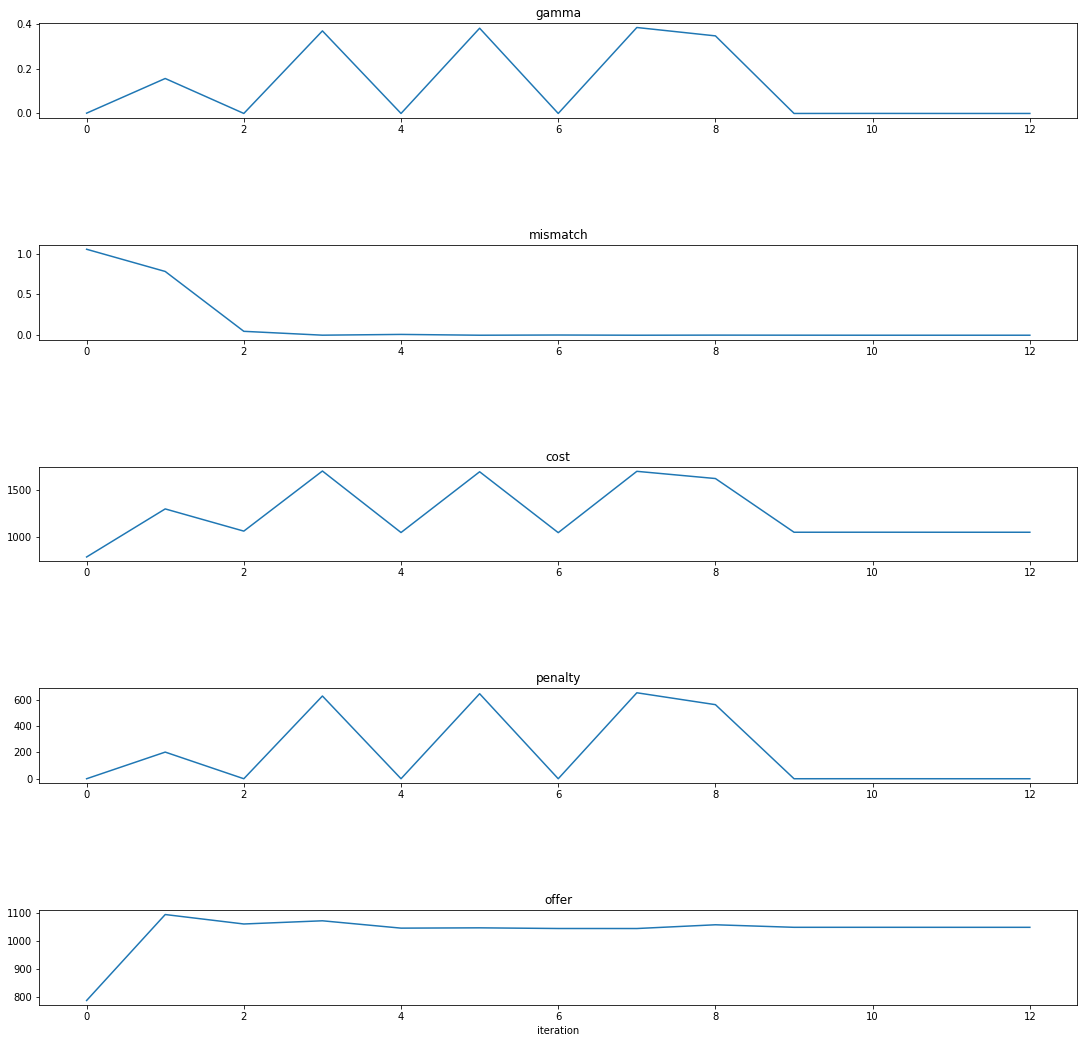


Step Sizes at bus n in iteration x:
               1             2             3             4             5
0   3.487345e-01  3.487345e-01  3.487345e-01  3.487345e-01  3.487345e-01
1   1.291881e-01  1.291881e-01  1.291881e-01  1.291881e-01  1.291881e-01
2   3.385198e-03  3.385198e-03  3.385198e-03  3.385198e-03  3.385198e-03
3   3.894625e-02  3.894625e-02  3.894625e-02  3.894625e-02  3.894625e-02
4   2.124987e-04  2.124987e-04  2.124987e-04  2.124987e-04  2.124987e-04
5   1.952724e-02  1.952724e-02  1.952724e-02  1.952724e-02  1.952724e-02
6   2.295590e-05  2.295590e-05  2.295590e-05  2.295590e-05  2.295590e-05
7   1.189795e-02  1.189795e-02  1.189795e-02  1.189795e-02  1.189795e-02
8   9.029733e-03  9.029733e-03  9.029733e-03  9.029733e-03  9.029733e-03
9   1.487375e-06  1.487375e-06  1.487375e-06  1.487375e-06  1.487375e-06
10  5.110195e-05  5.110195e-05  5.110195e-05  5.110195e-05  5.110195e-05
11  6.496758e-10  6.496758e-10  6.496758e-10  6.496758e-10  6.496758e-10
12  4.346963e-

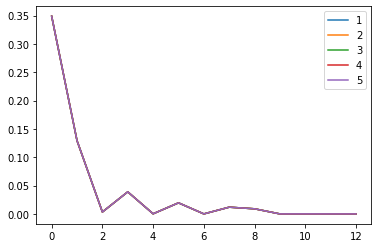

In [9]:
x1 = range(0,len(pc.gamma))
x2 = range(0,len(pc.mismatch))
x3 = range(0,len(pc.cost))
x4 = range(0,len(pc.penalty))
x5 = range(0,len(pc.penalty))

y1 = pc.gamma
y2 = pc.mismatch
y3 = pc.cost
y4 = pc.penalty
y5 = list(np.array(y3)-np.array(y4))

step_size_df = pd.DataFrame(pc.step_size_limits, columns= buses)
measures_df = pd.DataFrame({'gamma': y1, 'mismatch': y2, 'cost': y3, 'penalty': y4, 'offer': y5})
print(measures_df)

fig, axs = plt.subplots(5, 1)
fig.tight_layout()
fig.set_size_inches(16,16)
plt.xlabel('iteration')

axs[0].plot(x1, y1)
axs[0].set_title('gamma')

axs[1].plot(x2, y2)
axs[1].set_title('mismatch')

axs[2].plot(x3, y3)
axs[2].set_title('cost')

axs[3].plot(x4, y4)
axs[3].set_title('penalty')

axs[4].plot(x5, y5)
axs[4].set_title('offer')

plt.show()

print()
print("Step Sizes at bus n in iteration x:")
print(step_size_df)
step_size_df.plot()

## **Result Organization**

In [10]:
# Power injection
s_magnitude, s_phase =  pc.calc_magnitude_n_phase(pn_extract, qn_extract)
sn_df = pd.DataFrame({'bus': buses, 'magnitude': s_magnitude, 'pn': pn_extract, 'qn': qn_extract, 'phase': s_phase})

# Bus voltages
v_magnitude, v_phase = pc.calc_magnitude_n_phase(vnr_extract, vnj_extract)
vn_df = pd.DataFrame({'bus': buses, 'magnitude': v_magnitude, 'vnr': vnr_extract, 'vnj': vnj_extract, 'phase':v_phase})

# Current flow
ik_magnitude, ik_phase = pc.calc_magnitude_n_phase(ikr_extract, ikj_extract)
ik_df = pd.DataFrame({'lines': lines['nm']+lines['mn'], 'magnitude': ik_magnitude, 'ikr': ikr_extract, 'ikj': ikj_extract, 'phase' : ik_phase})


print('Power injection: ')
print(sn_df)
print()
print('Bus voltages: ')
print(vn_df)
print()
print('Current flow: ')
print(ik_df)
print()

Power injection: 
   bus     magnitude            pn            qn      phase
0    1  2.336091e+00  2.332052e+00  1.373280e-01  86.629903
1    2  1.342237e-08  1.342237e-08  0.000000e+00   0.000000
2    3  2.656999e-08  2.656999e-08  0.000000e+00   0.000000
3    4  1.584015e-08  1.308731e-08  8.923710e-09  55.711491
4    5  1.195538e+00  1.157320e+00 -2.998705e-01 -75.473681

Bus voltages: 
   bus  magnitude       vnr       vnj      phase
0    1   1.017878  0.961814  0.333149  70.895145
1    2   0.954248  0.921232  0.248839  74.884256
2    3   0.950056  0.905354  0.287992  72.354185
3    4   1.057272  0.958026  0.447226  64.975887
4    5   1.096211  0.952713  0.542234  60.353765

Current flow: 
     lines  magnitude       ikr       ikj      phase
0   (1, 2)   0.950049  0.949610 -0.028866 -88.258879
1   (1, 3)   1.417864  1.259449  0.651251  62.656883
2   (2, 3)   0.370558 -0.185567 -0.320747  30.051304
3   (2, 4)   0.272730 -0.234672  0.138964 -59.367485
4   (3, 5)   0.316074 -0.293890

## **Export**

In [11]:
export_directory = "sol_export"
if not os.path.exists(export_directory):
    os.makedirs(export_directory)


measures_df.to_csv(export_directory+"/measures.csv", sep=";")
step_size_df.to_csv(export_directory+"/step-size.csv", sep=";")
sn_df.to_csv(export_directory+"/power.csv", sep=";")
vn_df.to_csv(export_directory+"/voltage.csv", sep=";")
ik_df.to_csv(export_directory+"/current.csv", sep=";")

**Calculate IIS in case of infeasibility.**

In [ ]:
mb.write_iis()